# Entry Guidance

In [256]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn
from importlib import reload
seaborn.set_style("whitegrid")
from scipy.io import loadmat, savemat

from EntryGuidance import Mesh 
from EntryGuidance import EntryEquations as EE
from EntryGuidance import Convex_Entry as CVX
from EntryGuidance import MonteCarloV as MC
from EntryGuidance import Parachute 
from Utils import DA 
from Utils.submatrix import submatrix 
import EntryGuidance.Convex_PS as Convex
reload(Convex)
OCP = Convex.OCP
import cvxpy as cvx

In [2]:
reload(Mesh)
reload(EE)
reload(CVX)
reload(MC)
reload(DA)

<module 'Utils.DA' from 'E:\\Documents\\EDL\\Utils\\DA.py'>

In [296]:
traj,bank_profile = MC.solve_ocp(dr=870)

Total OCP solution time 22.69398069381714 s


In [16]:
mc = MC.MonteCarlo()
X,U_cvx,x_ref,u_ref,x_int = mc.reference_data(bank_profile, np.array(traj['state'])[-1,3])

r,th,ph,v,fpa,psi,bank = x_ref
h = r/1000-3397
Ef = mc.ref_sim.edlModel.energy(r,v,0)[-1]
print("Original final altitude: {:.2f} km".format(h[-1]))
print("Original final velocity: {:.2f}".format(v[-1]))

r,th,ph,v,fpa,psi,bank = X
h = r/1000-3397
Ef = mc.ref_sim.edlModel.energy(r,v,0)[-1]
print("Replanned final altitude: {:.2f} km".format(h[-1]))
print("Replanned final velocity: {:.2f}".format(v[-1]))
U = {}
U['CVX'] = U_cvx
U['Reference'] = u_ref

Generating reference data...
...done. 
(1447, 8)
Generating linearization about reference data...
...done.
Solving convex optimization problem...
status:        optimal_inaccurate
optimal value: 0.243
solution time:  1.685 s
setup time:     1.555 s
penalty value:  1.8692134768446257e-07

...done.

Original final altitude: 11.00 km
Original final velocity: 469.97
Replanned final altitude: 10.96 km
Replanned final velocity: 470.29


In [ ]:
plt.close('all')
fs = (16,8)
fontsize = 14
for xi,spec,label in zip([x_ref,X,x_int],['k--','r','b'],['Reference','CVX','Integrated']):
    if not "CVX" in label or True:
        r,th,ph,v,fpa,psi,bank = xi
        
        plt.figure(1, figsize=fs)
        plt.plot(v,r/1000-3397, spec,label=label)
        plt.xlabel('Velocity (m/s)', fontsize=fontsize)
        plt.ylabel('Altitude (km)', fontsize=fontsize)
        plt.legend(loc='best')

        plt.figure(10, figsize=fs)
        plt.plot(v[v<600],r[v<600]/1000-3397, spec, label=label)
        Parachute.Draw(10)
        plt.legend(loc='best')

        
        plt.figure(2, figsize=fs)
#         plt.plot(np.degrees(th),np.degrees(ph),spec,label=label)
#         plt.ylabel('Latitude (deg)', fontsize=fontsize)
#         plt.xlabel('Longitude (deg)', fontsize=fontsize)
        cr = (-3397*ph)
        plt.plot(th*3397,cr,spec,label=label)

#         plt.plot(th[cr>0.01]*3397,cr[cr>0.01],spec,label=label)
#         plt.plot(790, 0, 'ko', markersize=10, label='Target')

        plt.xlabel('Downrange (km)', fontsize=fontsize)
        plt.ylabel('Crossrange (km)', fontsize=fontsize)
        plt.legend(loc='best')
        
        plt.figure(3, figsize=fs)
        plt.plot(v,np.degrees(bank),spec,label=label)
        plt.xlabel('Velocity (m/s)', fontsize=fontsize)
        plt.ylabel('Bank (deg)', fontsize=fontsize)
        plt.legend(loc='best')



#         plt.figure(5, figsize=fs)
#         # plt.plot(v,np.degrees(th),spec)
#         plt.plot(v,-3397*ph,spec, label=label)
#         plt.ylabel('Crossrange (km)')
#         plt.xlabel('Velocity (m/s)', fontsize=fontsize)
        
        plt.figure(6, figsize=fs)
        plt.plot(v,np.degrees(psi),spec)
        plt.ylabel('Heading (deg)', fontsize=fontsize)
        plt.xlabel('Velocity (m/s)', fontsize=fontsize)
        
#         plt.figure(4, figsize=fs)
#         plt.plot(v,np.degrees(U[label]),spec)
#         plt.xlabel('Velocity (m/s)', fontsize=fontsize)
#         plt.ylabel('Bank rate (deg/s)', fontsize=fontsize)




plt.show()

In [280]:
class Entry(OCP):
    
    def __init__(self, current_state, scale=True, energy=True,):
        """current state should be the original states with units"""
        model=EE.Entry(Scale=scale, Energy=energy)
        self.model = model 
        self.x0 = self.model.scale(current_state)
        self.energy = energy
        self.scale = scale 
        
    def dynamics(self, x, t, u):
        # x comes in as six states and bank
        
        xnew = x[:6].copy()
        xnew = np.concatenate((xnew, np.zeros((1,t.size))), axis=0) # range to go
        xnew = np.concatenate((xnew, np.ones((1,t.size))*self.x0[-1]), axis=0)     # mass 
        
        unew = np.concatenate((x[6:], np.zeros((2, t.size))), axis=0)
        
        dx = self.model.dynamics(unew)(xnew, t)[:6]
        dx = np.concatenate((dx, (u[:,None].T/self.model.dE)), axis=0)
        return dx
    
    def mayer(self, xf):
#         return 0 
        return cvx.Problem(cvx.Minimize(-xf[0]))  # Maximize altitude 
        # return cvx.Problem(cvx.Minimize(cvx.abs(xf[2]))) # Minimize crossrange with abs
#         return cvx.Problem(cvx.Minimize(3397*cvx.power(xf[2], 2))) # Minimize crossrange with quadratic form 
    
    def lagrange(self, t, x, u, xr, ur):
#         print(u.shape)
        U = u.copy()
        U = np.append(U, u[-1])
#         X = x.copy()
#         X = np.append(X, x[-1])
        e = 0.5*xr[:,3]**2 - 1/xr[:,0]
#         de = np.abs(np.diff(e))
#         de = np.append(de, de[-1])
#         print(de)
        de = np.abs(e[0]-e[-1])
        return 1e-3*np.array([cvx.abs(ui-uri) for ui,uri in zip(U,U[1:])]) # Promotes zero changes in rate (stair-step bank rates)
#         return 1e-7*np.array([cvx.norm(ui-uri) for ui,uri in zip(U,U[1:])]) # Promotes small changes in rate - doesnt seem to work well 
#         return 1e-13*np.array([cvx.abs(ui[6]-uri[6]) for ui,uri in zip(X,X[1:])]) # Promotes flatter bank angles 

#         return 1e-5*np.array([cvx.abs(ui-uri) for ui,uri in zip(u,ur)])
#         return 1e-5*np.array([cvx.norm(ui-uri, 2) for ui,uri in zip(u,ur)])

#         return 1 * ((u-ur))**2
#         return 1e-3*np.array([cvx.norm(ui) for ui in u])
#         return np.array([cvx.norm(x) for ui in u])
#         return np.zeros((len(x),))

    def constraints(self, t, x, u, x_ref, u_ref):
        bc = [x[0] == x_ref[0]]   # Initial condition
        bc += [x[-1][3] < 475/self.model.vel_scale]      # Final velocity constraint
        
        bc += [x[-1][2] == 0]           # Zero crossrange as constraint
        bc += [x[-1][1] == x_ref[-1,1]] # Final downrange as constraint

#         bc += [cvx.abs(x[-1][6]) <= np.radians(10)] # Bank angle within ten deg of lift up 
        
        its = list(range(len(t)))
        constr = []
        for it,xi,xr,ui,ur in zip(its,x,x_ref,u,u_ref):
#             if it: # not first iter
#                 constr.append(cvx.abs((ui-u[it-1])) < np.radians(5.)*self.model.time_scale)
                
            
            # Control Limitations
            constr.append(cvx.abs(ui) < np.radians(20.)*self.model.time_scale) # maximum bank rate 
            constr.append(cvx.abs(xi[6]) < np.radians(89.))                    # bank angle limits
            
            # Trust regions 
#             constr.append(cvx.abs(xi[1]-xr[1]) < np.radians(0.3)) # longitude
#             constr.append(cvx.abs(xi[2]-xr[2]) < np.radians(0.15)) # latitude, 0.15 deg is ~9 km
#             constr.append(cvx.abs(xi[3]-xr[3]) < 10./self.model.vel_scale) # vel
#             constr.append(cvx.abs(xi[0]-xr[0]) < 500./self.model.dist_scale) # radius
#             constr.append(cvx.abs(xi[6]-xr[6]) < np.radians(15.)) # bank angle

        return bc + constr

    def jac(self, x, u):
        # u will be bank rate
        # x will be 6 states + bank angle
        
        # U needs to be [bank, Thrust, Mu]
        # X needs to be 6 states, downrange, mass

        # ought to be vectorized if possible 
        U = np.concatenate((x[6:], np.zeros((2,x.shape[1]))), axis=0).T
        X = np.concatenate((x[0:6], np.ones((2,x.shape[1]))*self.x0[-1]), axis=0).T     
                
        self.model.DA(True)    
        rows = list(range(6))
        cols = rows + [8]
        J = np.array([submatrix(self.model.jacobian(Xi, Ui, vectorized=False),rows,cols) for Xi, Ui in zip(X,U)]) # N x 8 x 11
        J2 = np.array([self.model.bank_jacobian(Xi, Ui, sdot) for Xi,Ui,sdot in zip(X, U, u)]) # N x 8 x 12?! 
        self.model.DA(False)
        
        B = np.zeros((X.shape[0], 7, 1))
        B[:,-1,0] = J2[:,0,-1]

        J2 = J2[:,:,cols]  # Get rid of the extra terms we dont care about
        A = np.concatenate((J,J2), axis=1)        
        return A, B
        
    def solve_ocp(self, dr=885., cr=1., fpa_min=-45, azi_max=5.):
        """ Solves for an optimal trajectory
            dr - total downrange flown
            fpa_min - lower bound on FINAL flight path angle (set too high and the problem will be infeasible)
            azi_max - two-sided bound on FINAL heading angle 
        
        """
        from Utils.gpops import entry
        from scipy.interpolate import interp1d
        from math import pi
        import time 
        
        def rad(num):
            return float(num)*pi/180.
        t0 = time.time()
        traj = entry([float(dr), float(cr), rad(fpa_min), rad(azi_max)])
        print("Total OCP solution time {:.2f} s".format(time.time()-t0))
        sigma = np.squeeze(np.array(traj['state'])[:,-1])

        bankProfile = interp1d(np.squeeze(np.squeeze(traj['energy'])), sigma, fill_value=(sigma[0],sigma[-1]), assume_sorted=False, bounds_error=False, kind='cubic')
        return bankProfile 
    
    def guess(self, dr=875, cr=0):
        """ Generates an initial guess """
        from EntryGuidance.Simulation import Simulation, Cycle, EntrySim
        from EntryGuidance.InitialState import InitialState
        from Utils.submatrix import submatrix
        from EntryGuidance.Mesh import Mesh
        from scipy.interpolate import interp1d
        
        print("Solving optimal control problem...")
        bankProfile = self.solve_ocp(dr=dr, cr=cr)

        print("    Integrating solution...")
        x0 = self.model.unscale(self.x0)
        Vf = 470.

        sim = Simulation(cycle=Cycle(0.2), output=False, **EntrySim(Vf=Vf))
        res = sim.run(x0, [lambda **d: bankProfile(d['energy'])])
        
        sigma_dot = np.diff(sim.control_history[:,0])/np.diff(sim.times)
        sigma_dot = np.append(sigma_dot, sigma_dot[-1]) # To make it the same length
        
        X = np.concatenate((self.model.scale(sim.history)[:,0:6], sim.control_history[:,0:1]), axis=1)
        
        # Output the correctly scaled guess 
        guess = {}
        self._guess = guess 
        
        guess['control'] = sigma_dot * self.model.time_scale# Bank rate 
        guess['state'] = X# 6 states + bank 
        if self.energy:
            guess['time'] = sim.df['energy'].values / (self.model.vel_scale**2)
        else:
            guess['time'] = self.model.scale_time(sim.times)
        
        guess['mesh'] = [4]*50
        print("Guess generated.")
        
        e = guess['time']
        edot = -sim.history[:,3]*sim.df['drag'].values / self.model.vel_scale / self.model.acc_scale
        guess['rate'] = edot

#         edot_est = np.diff(e) / np.diff(self.model.scale_time(sim.times ))
#         plt.plot(e[:-1], edot_est, '--')
#         plt.show()
        return guess.copy()
    
    def plot(self, T, U, X, J, meshpts):
        import seaborn
        seaborn.set_style("whitegrid")
        
        it = list(range(len(J)))
        
        
        plt.figure(1)
        plt.plot(it, J)
        plt.xlabel('Iteration')
        plt.xticks(it)
        plt.ylabel('Objective Function')
        
        
        
        for iteration, t, u, xs in zip(it,T,U,X):
            label = "{}".format(iteration)
            sigma = np.degrees(xs[6])
            x = xs[0:6] * self.model._scale[0:6, None]
            r,th,ph,v,gam,psi = x
            h = self.model.altitude(r, km=True)
            
            plt.figure(2)
            plt.plot(v, h, label=label)
            plt.xlabel('Velocity (m/s)')
            plt.ylabel('Altitude (km)')
            
            plt.figure(3)
            plt.plot(th*3397, -3397*ph, label=label)
            plt.xlabel('Downrange (km)')
            plt.ylabel('Crossrange (km)')
        
            plt.figure(4)
            plt.plot(t, sigma, label=label)
        
            plt.figure(5)
            plt.plot(t, np.degrees(u)/self.model.time_scale, label=label)
            plt.ylabel('Bank Rate (deg/s)')
            
        t, u, xs = T[-1], U[-1], X[-1]    
        label = "Opt"    
        sigma = np.degrees(xs[6])
        x = xs[0:6] * self.model._scale[0:6, None]
        r,th,ph,v,gam,psi = x
        h = self.model.altitude(r, km=True)

        plt.figure(6)
        plt.plot(v, h, label=label)
        plt.xlabel('Velocity (m/s)')
        plt.ylabel('Altitude (km)')
        plt.title("Final {:.2f} km at {:.0f} m/s".format(h[-1],v[-1]))

        plt.figure(7)
        plt.plot(th*3397, -3397*ph, label=label)
        plt.xlabel('Downrange (km)')
        plt.ylabel('Crossrange (km)')

        plt.figure(8)
        plt.plot(t, sigma, label=label)
        plt.ylabel('Bank Angle (deg)')
        
        plt.figure(9)
        plt.plot(t, np.degrees(u)/self.model.time_scale, label=label)
        plt.ylabel('Bank Rate (deg/s)')
        
#         try:
#             plt.figure(600)
#             plt.plot(self._guess['time'], self._guess['rate'])
#             plt.xlabel("Scaled Energy")
#             plt.ylabel("Scaled Energy Rate (wrt Scaled Time)")
#         except:
#             pass 

In [281]:
from EntryGuidance.InitialState import InitialState
entry = Entry(InitialState(), scale=False, energy=True)


Solving the OCP in the guess generation is slow so it gets its own cell

In [282]:
guess = entry.guess(dr=880., cr=0)

Solving optimal control problem...
Total OCP solution time 13.03 s
    Integrating solution...
Guess generated.


In [352]:
print(entry._guess['state'][550])

[ 3.42606332e+06  1.68402816e-01  2.00188749e-05  4.55018727e+03
 -1.00352125e-01  1.55074089e-03 -5.11580147e-02]


In [278]:
# don't want to actually start from true x0 
for key in guess.keys():
    if not key in 'mesh':
        guess[key] = guess[key][400:]



Iteration 0
status:        optimal_inaccurate
optimal value: 7.572
solution time:  1.562 s
setup time:     1.212 s
penalty value:  0.0008565439899294915

Mesh refinement resulted in 54 segments with 201 collocation points

Iteration 1
status:        optimal_inaccurate
optimal value: -0.995
solution time:  2.305 s
setup time:     2.185 s
penalty value:  6.904429281616968e-08

Relative change in cost function = 860.92%
Iteration 2
status:        optimal_inaccurate
optimal value: -0.999
solution time:  2.308 s
setup time:     2.114 s
penalty value:  7.523716552990412e-08

Relative change in cost function = 0.42%
Mesh refinement resulted in 58 segments with 313 collocation points

Iteration 3
status:        optimal_inaccurate
optimal value: -1.001
solution time:  3.288 s
setup time:     3.236 s
penalty value:  1.1503491124950391e-08

Relative change in cost function = 0.19%
Mesh refinement resulted in 73 segments with 429 collocation points

Iteration 4
status:        optimal_inaccurate
op

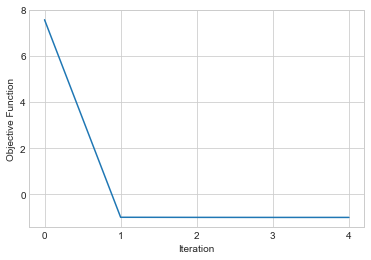

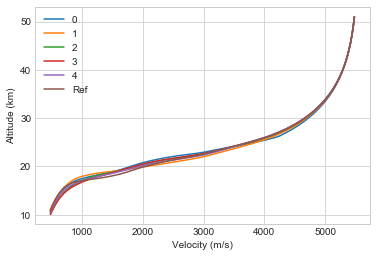

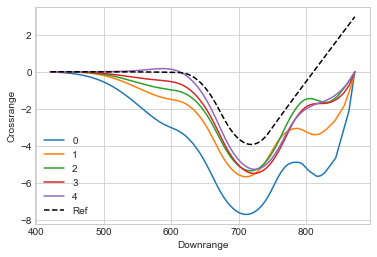

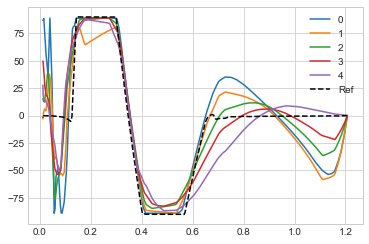

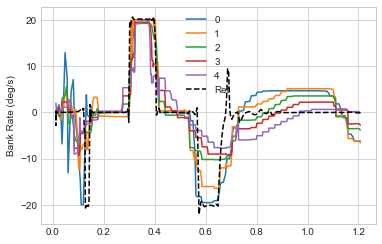

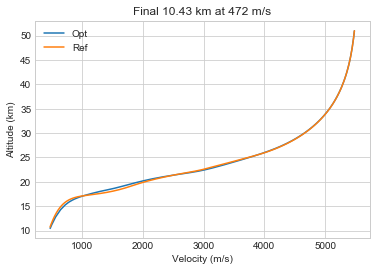

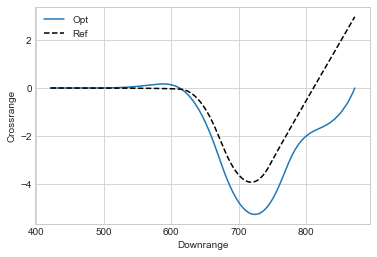

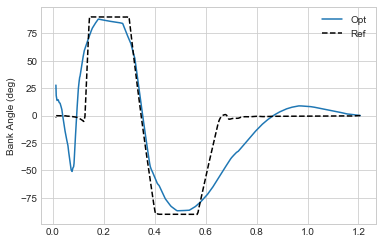

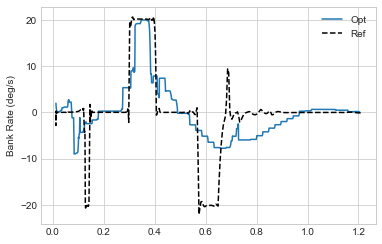

In [279]:
entry.solve(guess, max_iter=5, max_size=600, penalty=1e4)

x = guess['state']
r,th,ph,v,gamma,psi,bank = x.T
h = entry.model.altitude(r*entry.model.dist_scale, km=True)


plt.figure(2)
plt.plot(v*entry.model.vel_scale, h, label='Ref')
plt.legend()

plt.figure(3)
plt.plot(th*3397, ph*-3397, 'k--',label='Ref')
plt.xlabel('Downrange')
plt.ylabel('Crossrange')
plt.legend()

plt.figure(4)
plt.plot(guess['time'], np.degrees(bank), 'k--', label='Ref')
plt.legend()

plt.figure(5)
plt.plot(guess['time'], np.degrees(guess['control'])/entry.model.time_scale, 'k--', label='Ref')
plt.legend()

plt.figure(6)
plt.plot(v*entry.model.vel_scale, h, label='Ref')
plt.legend()

plt.figure(7)
plt.plot(th*3397, ph*-3397, 'k--',label='Ref')
plt.xlabel('Downrange')
plt.ylabel('Crossrange')
plt.legend()

plt.figure(8)
plt.plot(guess['time'], np.degrees(bank), 'k--', label='Ref')
plt.legend()

plt.figure(9)
plt.plot(guess['time'], np.degrees(guess['control'])/entry.model.time_scale, 'k--', label='Ref')
plt.legend()

### Model Checking
- Verify Jacobians (and possibly Hessian) by comparing $f(x+\delta x)\approx f(x) + J(x)\delta x$
- Verify again but in scaled variables 

In [63]:
model = EE.Entry(Scale=True)

In [243]:
idx = 100
state = np.array(guess['state'])[idx,0:6]
state = np.append(state, 0.)
state = np.append(state, 2804.)

state2 = np.array(guess['state'])[idx+1,0:6]
state2 = np.append(state2, 0.)
state2 = np.append(state2, 2804.)

control = [np.array(guess['state'])[idx,6], 0, 0]
control2 = [np.array(guess['state'])[idx+1,6], 0, 0]

control = [0, 0, 0]
control2 = [0.25, 0, 0]

state = state / model._scale 
state2 = state2 / model._scale 

print("FPA: {:.2f} deg".format(np.degrees(state[4])))

model.use_energy = True
F = model.dynamics(control)(state, 0)
model.DA(True)
rows = list(range(6))
cols = rows + [8]
J = submatrix(model.jacobian(state, control, vectorized=False),rows,cols)
A = J[:,rows]
B = J[:,-1]
model.DA(False)

F2 = model.dynamics(control2)(state2, 0)[:6]
F2a = F[:6] + A.dot((state2[0:6]-state[0:6])) + B.dot(control2[0]-control[0])
print("True Der   = {}".format(F2))
print("Lin Approx = {}".format(F2a))

err = np.abs(F2-F2a)
perr = np.abs(F2-F2a)/np.abs(F2) * 100
perr[np.isnan(perr)] = 0
print("Errors = {}".format((F2-F2a)))
print("Errors = {}".format(np.abs(F2-F2a)))
print("Errors = {}".format(err))

print("Percent Errors = {}".format(perr))
# print(err)
# print(perr)
imax = np.argmax(perr)
print("Maximum error = {:.4g}, {:.2f}%, in state {}".format(err[imax], perr[imax],imax))

FPA: -7.58 deg
True Der   = [ 6.12262820e-155 -1.55270759e-147 -7.66065144e-151  2.49704354e+003
 -1.62121712e+006  4.17588184e+005]
Lin Approx = [ 6.12266119e-155 -1.55269539e-147 -7.66004547e-151  2.49703717e+003
 -1.67322111e+006  4.20652925e+005]
Errors = [-3.29871587e-160 -1.22019699e-152 -6.05970277e-155  6.37197524e-003
  5.20039945e+004 -3.06474082e+003]
Errors = [3.29871587e-160 1.22019699e-152 6.05970277e-155 6.37197524e-003
 5.20039945e+004 3.06474082e+003]
Errors = [3.29871587e-160 1.22019699e-152 6.05970277e-155 6.37197524e-003
 5.20039945e+004 3.06474082e+003]
Percent Errors = [5.38774487e-04 7.85851113e-04 7.91016641e-03 2.55180782e-04
 3.20771314e+00 7.33914640e-01]
Maximum error = 5.2e+04, 3.21%, in state 4


Reachable Set Analysis from Matlab

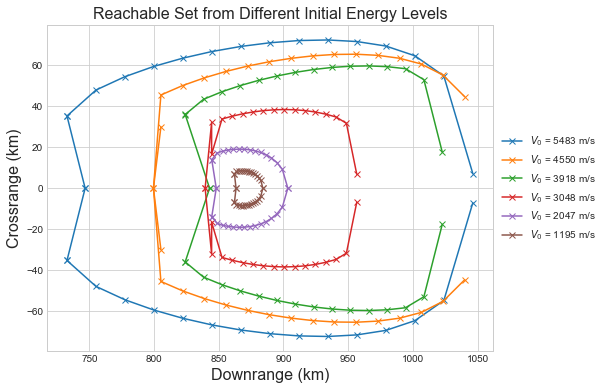

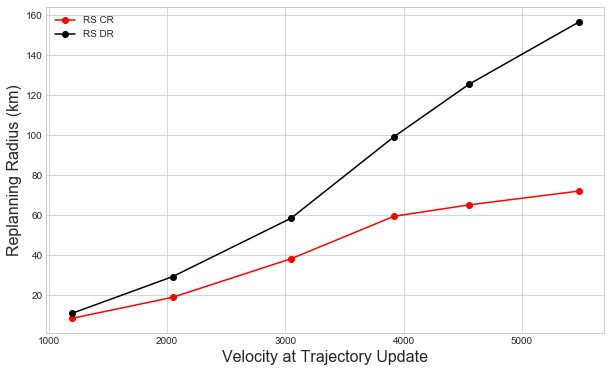

In [368]:
def collect(parent_dir):
    Collection = {}
    
    for rs in os.listdir(parent_dir): # for each reachable set computation
        dir_path = os.path.join(parent_dir, rs)    

        if not os.path.isdir(dir_path):
            continue 
            
        Data = []

        for filename in os.listdir(dir_path):
            if not filename.endswith('.mat'):
                continue

            Data.append(loadmat(os.path.join(dir_path, filename), squeeze_me=True))
        
        Collection[rs] = Data 
    return Collection


def plot_rs_radius(data, Ns=[400,550,600,675,800,1000], fs=16, figsize=(10,6)):   
    if Ns is None:
        Ns = data.keys()
    
    
    traj_lists = [data[str(N)] for N in Ns] # Nx x 18 
    v0 = np.array([traj_list[0]['state'][0,3] for traj_list in traj_lists])
    idx = np.argsort(v0)

    crs = np.array([[tr['state'][-1,2] for tr in traj_list] for traj_list in traj_lists]) # Soomething like 4 x 18 
    cr = np.max(np.abs(crs), axis=1)[idx]*3397
    
    drs = np.array([[tr['state'][-1,1] for tr in traj_list] for traj_list in traj_lists]) # Soomething like 4 x 18 
    dr = (np.max(drs, axis=1) - np.min(drs, axis=1))[idx]*3397/2

    v0 = v0[idx]
    
    plt.figure(2, figsize=figsize)
    plt.plot(v0, cr,'ro-', label='RS CR')
    plt.plot(v0, dr,'ko-', label='RS DR')
    plt.xlabel('Velocity at Trajectory Update', fontsize=fs)
    plt.ylabel('Replanning Radius (km)', fontsize=fs)
    plt.legend()
    
    
def plot_rs(data, Ns=[400,550,600,675,800,1000], fs=16, figsize=(8,6)):
    if Ns is None:
        Ns = data.keys()
        
    for N in Ns:    
        
        traj_list = data[str(N)]
        xf = np.array([traj['state'][-1] for traj in traj_list]).T 
        
        idxs = list(np.argsort(xf[1])[:-1])
        imin = np.argmin(xf[2,idxs]) # zero crossrange point 
        idx = [idxs[imin]] + idxs[:imin] + idxs[1+imin:]

        
        plt.figure(1, figsize=figsize)
        L = plt.plot(xf[1,idx]*3397, xf[2,idx]*3397, 'x-', label="$V_0$ = {:.0f} m/s".format(traj_list[0]['state'][0,3]))
        plt.plot(xf[1,idx]*3397, -xf[2,idx]*3397, 'x-', color=L[-1].get_color())
    plt.xlabel('Downrange (km)', fontsize=fs)
    plt.ylabel('Crossrange (km)', fontsize=fs)
    plt.title('Reachable Set from Different Initial Energy Levels', fontsize=fs)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    
    
RS = collect("../GitHub/Research/Matlab/results/")
plot_rs(RS)
plot_rs_radius(RS)

In [363]:
RS.keys()

dict_keys(['1000', '400', '550', '600', '675', '800'])

Next, we need a quick utilities for integrating a CVX solution, plotting the integration vs optimization, and computing a metric for quantifying the discrepancy. The metric could be something like $\int_{E_0}^{E_f} ||x_{int}-x_{opt}||  dE$, or alternatively, depending solely on the difference in final states $||x_{int}(E_f)-x_{opt}(E_f)||$? Although these might tell a story, perhaps using several metrics with physical meaning might be better, such as the individual differences between final altitude, and final horizontal difference (no reason to separate DR/CR errors, I think)

# Landing Guidance - SRP
## Differential Flatness (BSpline) + SQP approach

In [ ]:
from EntryGuidance import bsplinePDG as PDG
reload(PDG)
PDG.optimize()

## GPOPS Solution to SRP 

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint 
import matplotlib.pyplot as plt 
import seaborn
seaborn.set_style('whitegrid')
from scipy.io import savemat, loadmat
import os

from Utils.gpops import srp as srp_opt
from EntryGuidance.TrajPlot import TrajPlot

In [ ]:
x0 = [-3200., 0., 3200., 625., 60., -270., 8500.]
traj = srp_opt((x0,))
# print((traj['time'][-1]))
u = np.array(traj['control']).T
# plt.figure(1, figsize=(14,8))
# TrajPlot(*(np.array(traj['state'])[:,0:3].T), T=(u[0]*u[1:4]).T/1000 , show=True, figNum=1)

In [2]:
import chaospy as cp
x0 = [-3200., 0., 3200., 625., 0., -270., 8500.]
ux = cp.Uniform(x0[0]-1200,x0[0]+400)
uy = cp.Uniform(x0[1]-2000,x0[1]+2000)
uz = cp.Uniform(x0[2]-600,x0[2]+800)
uu = cp.Uniform(x0[3]-40,x0[3]+100)
uv = cp.Uniform(x0[4]-100,x0[4]+100)
uw = cp.Uniform(x0[5]-40,x0[5]+40)
D = cp.J(ux,uy,uz,uu,uv,uw)

R = D.sample(999, 'S').T
# R = uz.sample(100,'S')
print(R.shape)

(1000, 6)


From each trajectory, save the solution vector (7 initial costates + 1 final time) as well as the entire array of states and controls

In [ ]:
x0 = [-3200., 0., 3300., 625., 0., -270., 8500.]
savedir = "./data/mae278/test"
it0 = len([1 for file in os.listdir(savedir) if file.endswith('.mat')])
for it,r in enumerate(R, start=it0):
#     print("Solving from initial state {} m".format(r))
#     print("Iter {}".format(it))

    r = [float(ri) for ri in r]
    x0[0:6] = r
#     x0[2] = float(r)
    traj = srp_opt((x0,))
    
    
    t = np.array(traj['time']).squeeze()
    l = np.array(traj['costate'])
    sol = l[0].tolist() + [t[-1]]
    traj['time'] = t
    traj['costate'] = l
    traj['state'] = np.array(traj['state'])
    traj['control'] = np.array(traj['control'])
    traj['sol'] = sol
    traj.pop('timeRadau', None)
    traj.pop('controlRadau', None)
    traj.pop('pathmultipliers', None)

    savemat(savedir+"/srp_{}.mat".format(it), traj)

In [ ]:
loaddir = "./data/mae278/alt_sweep_fixed/"
plt.figure(100, figsize=(12,12))
z0 = []
sol = []
tf = []
for file in os.listdir(loaddir):
#     print(file)
    if not file.endswith('.mat'):
        continue
    data = loadmat(loaddir+file, squeeze_me=True)
    x = data['state'].T
#     tf.append(np.array(data['time']).squeeze()[-1])
    print(np.max(x[0]))
    if np.all(x[0]<=0):
        TrajPlot(*x[0:3], figNum=100)
    z0.append(x[2,0])
    sol.append(data['sol'])
I = np.argsort(z0)
# plt.figure(16,figsize=(12,12))
# plt.plot(np.array(z0)[I],np.array(sol)[I,:])
# plt.xlabel('Initial Altitude (m)')
# plt.ylabel('Costates')
# plt.legend(['x','y','z','u','v','z'])

In [25]:
print(np.mean(tf))
print(np.max(tf))
print(np.min(tf))

15.228431129802608
19.132580241869892
11.8704813225191


## Iterative Convex Optimization of Nonlinear Systems (ICONS)


In [9]:
import EntryGuidance.Convex_PS as Convex
from importlib import reload
reload(Convex)
OCP = Convex.OCP
import cvxpy as cvx
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint 
import matplotlib.pyplot as plt 
import seaborn
seaborn.set_style('whitegrid')


In [10]:
class SRP(OCP):
    def __init__(self, x0, xf, ubounds, xf_idx=None, scale=1):
        # xf is a REDUCED list of final states, len(xf)=len(xf_idx)
        # xf_idx is a list of indices for fixed final states such that x[xf_idx] = xf
        self.vei = 0.00034 # escape velocity inverse= 1/(Isp*g0), system is linear with no mass loss when = 0        
        
        self.x0 = np.array(x0)
        
        if xf_idx is not None:
            assert len(xf)==len(xf_idx)
            self.xfi = xf_idx
        else:
            self.xfi = list(range(self.x0.size))
            
        self.scale = scale  
        self.ubounds = np.asarray(ubounds) / self.scale
        self.x0 = np.array(x0) / self.scale
        self.xf = np.array(xf)
        
    def dynamics(self, x, t, U):
#         u = U(t).T * self.scale
        u = U.T * self.scale
        p = x[0:3] * self.scale
        v = x[3:6] * self.scale
        m = x[6]   * self.scale
        
        g = np.array([0, 0, 3.71])
        if x.ndim>1:
            g = g[:,None]
        dx = np.empty(x.shape, dtype=x.dtype)     
        dx[0:3] = v
        dx[3:6] = u/m - g
        dx[6] = -self.vei * (u[0]**2 + u[1]**2 + u[2]**2)**0.5   
        return dx/self.scale
        
    def jac(self, x, u):
        u = u.copy() * self.scale
        m = x[6]*self.scale
        
        A = np.zeros((x.shape[1],7,7))
        A[:, 0:3][:, :, 3:6] = np.eye(3)
        A[:, 3:6][:, :, 6] = (-u/m**2).T

        B = np.zeros((x.shape[1],7,3))
        B[:, 3, 0] = 1/m
        B[:, 4, 1] = 1/m
        B[:, 5, 2] = 1/m 
        B[:, 6] = (-self.vei * u/(u[0]**2 + u[1]**2 + u[2]**2)**0.5).T
        return A,B 
    
    def check_jac(self, x, u):
        from Utils.DA import compute_jacobian
        
        xu = np.concatenate((x,u), axis=0)        
        return compute_jacobian(lambda xu: self.dynamics(xu[:7], 0, lambda t: xu[7:]), xu)
    
    def constraints(self, t, x, u, x_ref, u_ref):
        bc = [x[-1][self.xfi] == self.xf, x[0] == x_ref[0]]
        
        umin, umax = self.ubounds
        dT_max = 1*umax # Newtons
        dm = 500/self.scale # kg 
        constr = []
        for ti, xr in zip(t, x_ref):
#             du = u[ti]-u_ref[ti]
#             if ti>t[0]:
#                 dudt = (u[ti] - u[ti-1])
#                 constr += [cvx.norm(dudt) < 0.2 * umax]
            constr += [cvx.norm(u[ti])/umax <= 1] # Convex upper bound on total thrust
#             constr += [cvx.norm(u[ti])/umin >= 1] # Non-convex lower bound on total thrust
#             constr += [cvx.norm(du) <= dT_max]   # Convex upper bound on change in thrust

#             constr += [u[ti][1] > 0]
            if ti:
                constr += [x[ti][-1]-x[ti-1][-1] <= 0] # non-increasing mass 
#             constr += [cvx.norm(x[ti][-1]-xr[-1]) < dm] # Bound on change in mass 
        return constr + bc
        
    def mayer(self, xf):
        return 0 
#         return cvx.Problem(cvx.Minimize(-xf[-1]))
    
    def lagrange(self, t, x, u, xref, uref):
        return np.array([cvx.norm(ui) for ui in u])/self.ubounds[1]
#         return np.zeros((len(x),))
        
    def plot(self, T, U, X, J, meshpts):
        """ Plots the results of the successive convex optimization """
        xopt = X[-1] * self.scale 
        uopt = U[-1] * self.scale 
        label = "Convex"
        print("Fuel consumed = {:.1f} kg".format(xopt[-1,0]-xopt[-1,-1]))
        
        plt.figure(1)
        plt.plot(T[-1], xopt[-1], label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Mass (kg)')
        
        plt.figure(2)
        plt.plot(T[-1], xopt[0:3].T, label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')
        
        plt.figure(3)
        plt.plot(T[-1], xopt[3:6].T, label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        
        plt.figure(4)
        plt.plot(T[-1], np.linalg.norm(uopt, axis=1), label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Thrust (N)')
        
        plt.figure(5)
        plt.plot(T[-1], uopt/np.linalg.norm(uopt, axis=1)[:,None], label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Control Directions')
        
        plt.figure(6)
        if np.max(J)/(np.min(J)+1e-8) > 10:
            plt.semilogy(J,'o-')
        else:
            plt.plot(J,'o-')
        plt.xlabel('Iteration')
        plt.ylabel('Cost Function')
        
#         self.mesh.plot()
        
    def guess(self):
        """ Generates a dictionary containing an initial guess at the solution"""
        guess = {}
        if False:
            data = loadmat("./data/mae278/srp_10.mat", squeeze_me=True)
            guess['time'] = data['time']
            guess['state'] = data['state']/self.scale 
            guess['mesh'] = [4]*3
            guess['control'] = data['control'][:,0:1]*data['control'][:,1:4]/self.scale 
            
        else: # Simple linear guess 
            guess['time'] = np.linspace(0,16)
            guess['mesh'] = [4]*3

            x_guess = np.array([np.linspace(x,1) for x in self.x0]).T
            x_guess[:,6] = np.linspace(self.x0[-1], 0.72*self.x0[-1])
            
            t = np.linspace(0,16,51)
            v = np.array([np.linspace(x, 1, 51) for x in self.x0[3:6]]).T
            guess['state'] = x_guess
            guess['control'] = np.diff(v, axis=0)/np.diff(t)[:,None] * x_guess[:,6:]
        return guess 
    
    def gpops(self):
        """ Generates the optimal solution using GPOPS II """
        from Utils.gpops import srp as srp_opt
        traj = srp_opt(([float(x0*self.scale) for x0 in self.x0],))

        u = np.array(traj['control']).T
        t = traj['time']
        x = np.array(traj['state']).T
        label = "GPOPS"
        plt.figure(1)
        plt.plot(t, x[-1], '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Mass (kg)')
        plt.legend()
        plt.figure(2)
        plt.plot(t, x[0:3].T, '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')
        plt.legend()
        plt.figure(3)
        plt.plot(t, x[3:6].T, '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        plt.legend()
        
        plt.figure(4)
        plt.plot(t, u[0], '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Thrust (N)')
        plt.legend()
        
        plt.figure(5)
        plt.plot(t, u[1:4].T, '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Control Directions')
        plt.legend()

In [11]:
m0 = 8500
x0 = np.array([-3000., 0, 2800, 625., -80, -270., m0])
xf = np.zeros((6,))
xfi = np.arange(6)
ubnds = np.array([40,70])*m0 # Newtons 
srp = SRP(x0=x0, xf=xf, xf_idx=xfi, ubounds=ubnds, scale=m0)
print(srp.ubounds)

[40. 70.]


Iteration 0
status:        optimal
optimal value: 17.332
solution time:  0.046 s
setup time:     0.02 s
penalty value:  0.0007778201958046753

Mesh refinement resulted in 3 segments with 13 collocation points

Iteration 1
status:        optimal
optimal value: 10.26
solution time:  0.068 s
setup time:     0.029 s
penalty value:  3.65088363524917e-08

Relative change in cost function = 68.93%
Iteration 2
status:        optimal
optimal value: 9.912
solution time:  0.069 s
setup time:     0.028 s
penalty value:  9.46153722180405e-08

Relative change in cost function = 3.50%
Mesh refinement resulted in 6 segments with 19 collocation points

Iteration 3
status:        optimal
optimal value: 9.89
solution time:  0.172 s
setup time:     0.066 s
penalty value:  2.889764517739681e-08

Relative change in cost function = 0.22%
Mesh refinement resulted in 8 segments with 37 collocation points

Iteration 4
status:        optimal
optimal value: 9.882
solution time:  0.242 s
setup time:     0.129 s
pe

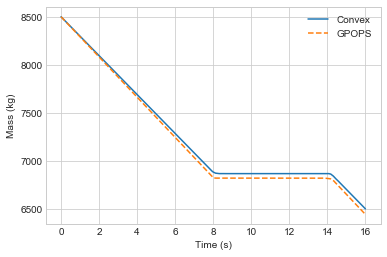

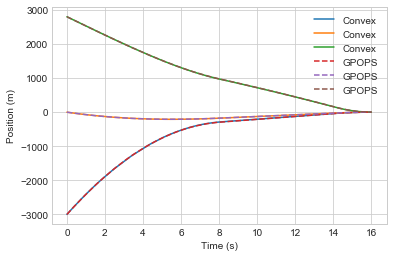

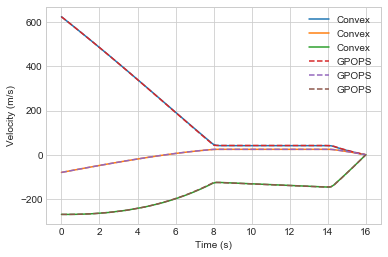

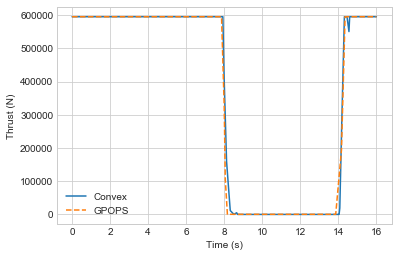

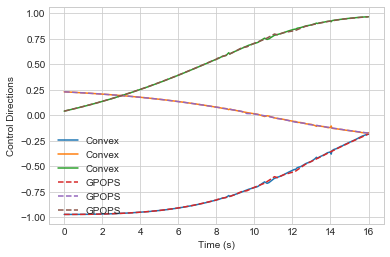

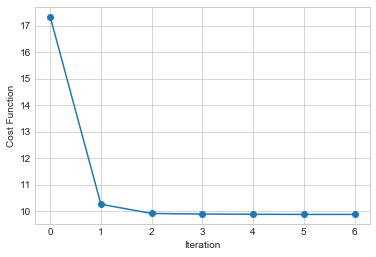

In [13]:
srp.solve(srp.guess(), max_size=300, max_iter=25) #scaling=np.array([10,5,10,1,1,1,15])*5
srp.gpops()


Verify that jacobian is implemented correctly 

In [148]:
x0 = srp.x0
u0 = np.array([70.,70,70])/srp.scale
u = np.array([60.,75,65])/srp.scale
x = np.array([-3100., 350, 3000, 615., -70, -260., m0*0.98])/srp.scale
# print(x)
# print(x0)
f0 = srp.dynamics(x0, 0, lambda t: u0)
f = srp.dynamics(x, 0, lambda t: u)
print(f)
print(f0)
A,B = srp.jac(np.array([x0,x]).T, np.array([u0,u]).T)
flinear = f0 + (A[0].dot(x-x0) + B[0].dot(u-u0))
print(flinear)
print(np.linalg.norm(f-flinear, np.inf))

[ 7.23529412e-02 -8.23529412e-03 -3.05882353e-02  8.47397783e-07
  1.05924723e-06 -4.35552574e-04 -4.63896540e-06]
[ 7.35294118e-02 -9.41176471e-03 -3.17647059e-02  9.68858131e-07
  9.68858131e-07 -4.35501730e-04 -4.84974226e-06]
[ 7.23529412e-02 -8.23529412e-03 -3.05882353e-02  8.49826990e-07
  1.05743945e-06 -4.35551557e-04 -4.61880215e-06]
2.0163248380274508e-08


In [149]:
A,B = srp.jac(np.array([x0,x]).T, np.array([u0,u]).T)
J = srp.check_jac(x, u)

print(J.shape)
print(A.shape)
print(B.shape)
Jana = np.concatenate((A[1],B[1]), axis=1)
err = np.abs(Jana-J)
print(np.linalg.norm(err, np.inf))
# print(err)

(7, 10)
(2, 7, 7)
(2, 7, 3)
1.3552527156068805e-19


## Indirect Approach

In [7]:
# These are closed loop dynamics that depend on the initial costate 
def dynamics(x, t, l0):
    # Problem constants
    Isp = 290;
    g0 = 9.81;
    ve = Isp*g0;
    Tmax = 70*8500
    Tmin = 40*8500
    
    # States being integrated
    r = x[0:3]
    v = x[3:6]
    m = x[6]
    lm = x[7] # Mass costate 
    
    # Costates
    lr = l0[0:3]
    lv0 = l0[3:6]
    lv = lv0 - lr*t
    u = -lv/np.linalg.norm(lv) # Optimal thrust direction
    
    # Optimal thrust magnitude
    S = -lm/ve + np.dot(lv, u)/m
    if S < 0:
        T = Tmax
    else:
        T = Tmin
    
    # State derivatives
    g = np.array([0,0,3.71])
    dx = np.empty(x.shape)     
    dx[0:3] = v
    dx[3:6] = T*u/m - g
    dx[6] = -T/ve    
    dx[7] = T*np.dot(lv, u)/m**2
    return dx

In [7]:
# l0 = np.array([0.204346904081385,	0.0663646852284269,	0.201041129500207,	3.17235427027352,	0.470730385571971,	0.565067899039915,	-0.748860889946803])
# x0 = np.array([-3200., 400, 3200, 625., 0, -270., m0, l0[-1]])
# tf = 14.0035
data = loadmat("./data/mae278/srp_566.mat", squeeze_me=True)
x0 = data['state'][0]
l0 = data['costate'][0]
x0 = np.append(x0, l0[-1])
tf=16
print("True prop usage = {} kg".format(data['state'][0,6]-data['state'][-1,6]))

True prop usage = 2412.5166200060476 kg


In [10]:
data = loadmat("./data/mae278/srp_566.mat", squeeze_me=True)
x0 = data['state'][0]
l0 = data['costate'][0]
x0 = np.append(x0, l0[-1])
t = np.linspace(0,tf)
X = odeint(dynamics, x0, t, args=(l0,))
print("Miss distance: {:.1f} m".format(np.linalg.norm(X[-1,:3])))
print("Velocity error: {:.1f} m".format(np.linalg.norm(X[-1,3:6])))
print("Prop used: {:.2f}".format(X[0,6]-X[-1,6]))

Miss distance: 54.4 m
Prop used: 2426.57


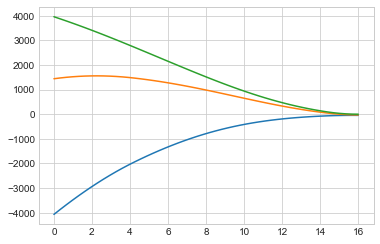

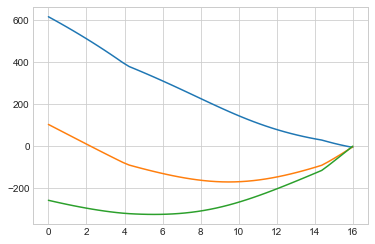

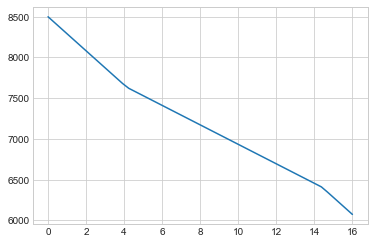

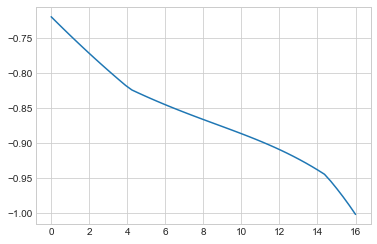

In [9]:
plt.figure()
plt.subplot(131)
plt.plot(t, X[:,0:3])
plt.subplot(132)
plt.plot(t, X[:,3:6])
plt.subplot(133)
plt.plot(t, X[:,6])
# plt.figure()
# plt.plot(t, X[:,7])

In [7]:
from EntryGuidance import Riccati
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint 
import matplotlib.pyplot as plt 


In [8]:
A = lambda x: np.array([x]).squeeze()
B = lambda x,u: np.array([1+x**2])
C = lambda x: np.array([1]) # Output equation linearization 
Q = lambda x: np.array([1-0.1*x**2]).squeeze() # State weight - less weight when far away 
R = lambda t: np.array([0.5/(1+t)]) # Control weight
z = lambda t: np.array([1+np.sin(t)+0.2*np.cos(2*t)/2]) #np.array([0]) # Reference trajectory
F = lambda x: Q(x)/10 #np.array([0]) # Final State weight 

tf = 12

x0 = np.array([1])
x, u, K = Riccati.ASRE(x0, tf, A, B, C, Q, R, F, z, tol=1e-3, max_iter=50, n_discretize=5000)
t = np.linspace(0, tf, x.size)

Uc = lambda T,X: interp1d(t, u, axis=0, bounds_error=False, fill_value=0)(T) - interp1d(t, K.squeeze(), axis=0, bounds_error=False, fill_value=0)(T)*(X - interp1d(t, x, axis=0, bounds_error=False, fill_value=0)(T))
Uo = lambda T,X: interp1d(t, u, axis=0, bounds_error=False, fill_value=0)(T) 

d = lambda x,t: 0.1*np.sin(t)*x
f = lambda x,t,u: x**2 + (1+x**2)*u(t,x) + d(x,t)

x_ol = odeint(f, x0, t, args=(Uo,)) # This should match with zero error essentially 
x_cl = odeint(f, np.linspace(0,2,10), t, args=(Uc,))
u_cl = [Uc(ti,xi) for ti,xi in zip(t,x_cl.squeeze())]
ref = z(t).squeeze()

Approximating Sequence of Riccati Equations
Max iterations: 50
Current iteration: 1
Current cost: 0.7895710251969738
Current iteration: 2
Current cost: 0.6088560399458006
Current iteration: 3
Current cost: 0.5991445034266731
Current iteration: 4
Current cost: 0.5963617844606172
Current iteration: 5
Current cost: 0.5960904171646377
Convergence achieved. 


E:\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


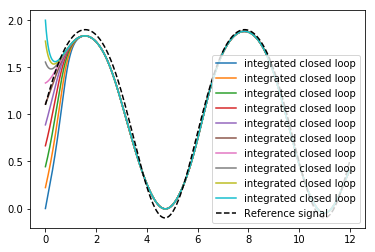

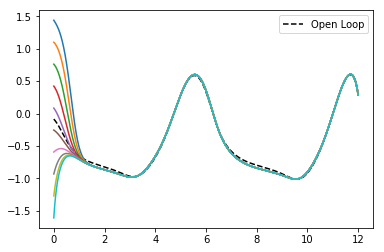

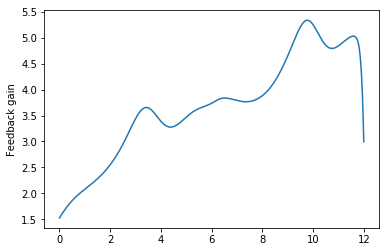

In [9]:
# plt.plot(t, x, 'mo',label='approx')
# plt.plot(t, x_ol, 'k-^', label='integrated open loop')
plt.plot(t, x_cl, label='integrated closed loop')
plt.plot(t, ref, 'k--', label='Reference signal')

plt.legend()

plt.figure()
plt.plot(t, u, 'k--', label='Open Loop')
plt.plot(t, u_cl)
plt.legend()

plt.figure()
plt.plot(t, K.squeeze())
plt.ylabel('Feedback gain')
plt.show()

## Closed loop covariance propagation
How does saturation effect the evolution?

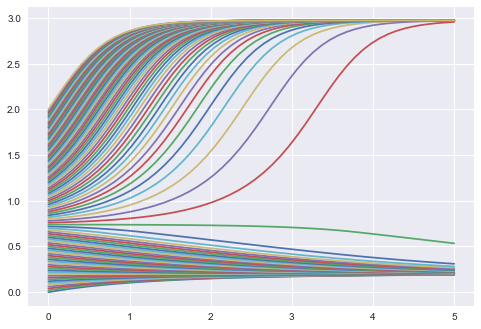

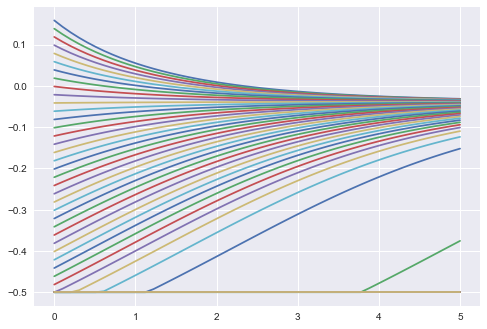

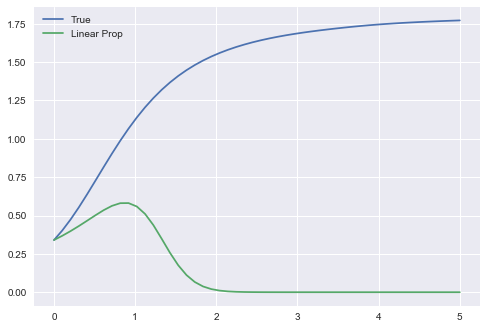

In [5]:
from EntryGuidance.Unscented import Transform 
tf = 5

x0 = np.linspace(0.,2,101)
t = np.linspace(0, tf, 50)

umax = 0.5
k = 1.
U = lambda t,x: np.clip(-np.sin(1)-k*(x-1), -umax, umax)
f = lambda x,t: np.sin(x)*x + U(t,x)
fp= lambda p,t,x: 2*p*(np.sin(x(t)) + x(t)*np.cos(x(t)) - k)

x = odeint(f, x0, t)
x_mean = odeint(f, np.mean(x0), t)
# x_mean = np.mean(x, axis=1)

u = [U(ti, xi) for ti,xi in zip(t,x.squeeze())]
P =  np.var(x, axis=1)
xt = interp1d(t,x_mean, axis=0, bounds_error=False, fill_value=(x_mean[0],x_mean[-1]))
Plin = odeint(fp, P[0], t, args=(xt,))

plt.figure()
plt.plot(t,x)

plt.figure()
plt.plot(t,u)

plt.figure()
plt.plot(t,P, label='True')
plt.plot(t,Plin, label='Linear Prop')
plt.legend()
plt.show()

In [1]:
import cvxpy as cvx

In [4]:
n = 3
x = cvx.Variable(n)
H = np.diag([1,-1,1.])
c = np.random.random((n,))

# print cvx.quad_form(x,H)
# print x[0]
constraint = [cvx.quad_form(x,np.abs(H)) < 1]
# constraint = [(x[0]**2 - x[1]**2 + x[2]**2)**2 < 1]

problem = cvx.Problem(cvx.Minimize(c*x), constraint)
problem.solve()
print x.value
print x.value.A.T.dot(np.abs(H)).dot(x.value.A)

[[-0.59096725]
 [-0.39423826]
 [-0.70379961]]
[[1.]]


In [7]:
print (cvx.quad_form(x,(H)) < 1).is_dcp()

False


e:\anaconda\lib\site-packages\cvxpy\atoms\quad_form.py:82: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
